# Infino - LangChain LLM Monitoring Example

This example shows how one can track the following while calling OpenAI models via LangChain:

* prompt input,
* response from chatgpt or any other LangChain model,
* latency,
* errors,
* number of tokens consumed

In [1]:
import sys

# Install necessary dependencies.
!pip install matplotlib

# Remove the sys.path.append(..) and uncomment `!pip install langchain` after merging the PR for Infino/LangChain integration.
sys.path.append("../../../../langchain")
#!pip install langchain

!pip install infinopy

import datetime as dt
from infinopy import InfinoClient
import json
from langchain.llms import OpenAI
from langchain.callbacks import InfinoCallbackHandler
import matplotlib.pyplot as plt
import matplotlib.dates as md
import os
import time
import sys

## Start Infino server, initialize the Infino client


In [2]:
# Start server using the Infino docker image.
!docker run --rm --detach --name infino-example -p 3000:3000 infinohq/infino:latest

# Create Infino client.
client = InfinoClient()

5b8bec7c381fecf2be35fbc04211846d4c22bfa8b65a2ebd86b6907b3cf41ec5


## Read the questions dataset

In [3]:
# Read the questions. These are a subset of questions from Stanford's QA dataset - 
# https://rajpurkar.github.io/SQuAD-explorer/
fh = open("../datasets/stanford-qa-subset.txt")
lines = fh.readlines()
fh.close()

questions = []
for line in lines:
  if not line.startswith("#"):
    questions.append(line.strip())

## LangChain OpenAI Q&A; Publish metrics and logs to Infino

In [4]:
# Set your key here.
#os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"

# Create callback handler. This logs latency, errors, token usage, prompts as well as prompt responses to Infino.
handler = InfinoCallbackHandler(model_id="test_openai", model_version="0.1", verbose=False)

# Create LLM.
llm = OpenAI(temperature=0.1)

# Number of questions to ask the OpenAI model. We limit to a short number here to save $$ while running this demo.
num_questions = 10

questions = questions[0:num_questions]
for question in questions:
    print(question)

    # We send the question to OpenAI API, with Infino callback.
    llm_result = llm.generate([question], callbacks=[handler])
    print(llm_result)

In what country is Normandy located?
generations=[[Generation(text='\n\nNormandy is located in France.', generation_info={'finish_reason': 'stop', 'logprobs': None})]] llm_output={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 7, 'total_tokens': 16}, 'model_name': 'text-davinci-003'} run=RunInfo(run_id=UUID('dfa2a189-b9a2-451f-9b4b-6ba98ab93a92'))
When were the Normans in Normandy?
generations=[[Generation(text='\n\nThe Normans first arrived in Normandy in 911 AD, when the French King Charles the Simple granted them the region in exchange for their help in defending the kingdom against Viking invasions.', generation_info={'finish_reason': 'stop', 'logprobs': None})]] llm_output={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 8, 'total_tokens': 46}, 'model_name': 'text-davinci-003'} run=RunInfo(run_id=UUID('a11eb5cd-86be-4efa-81d6-9d5a3f6889cd'))
From which countries did the Norse originate?
generations=[[Generation(text='\n\nThe Norse originated from Scandinavia, w

## Create Metric Charts

We now use matplotlib to create graphs of latency, errors and tokens consumed.

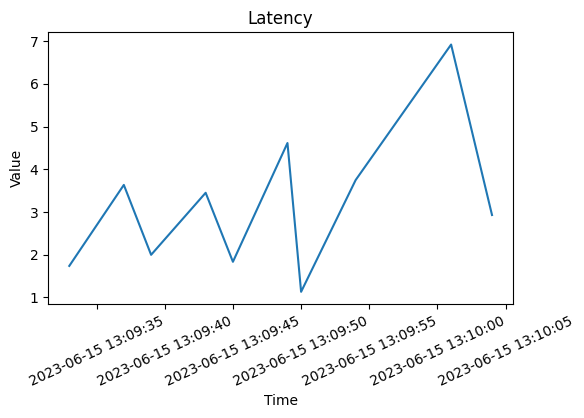

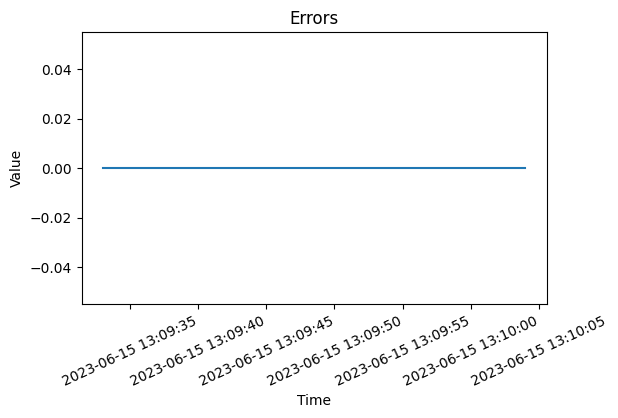

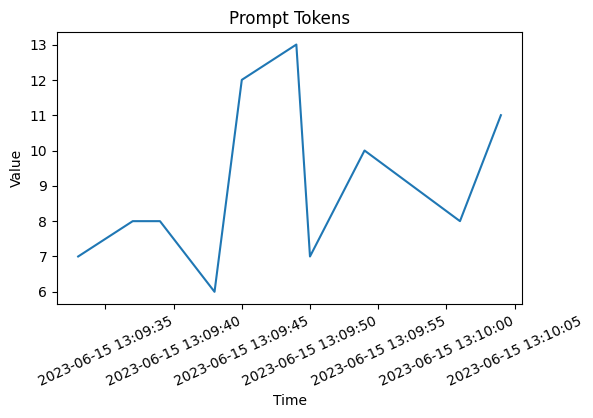

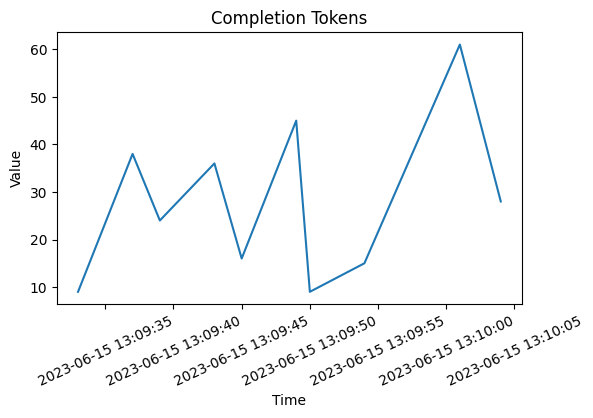

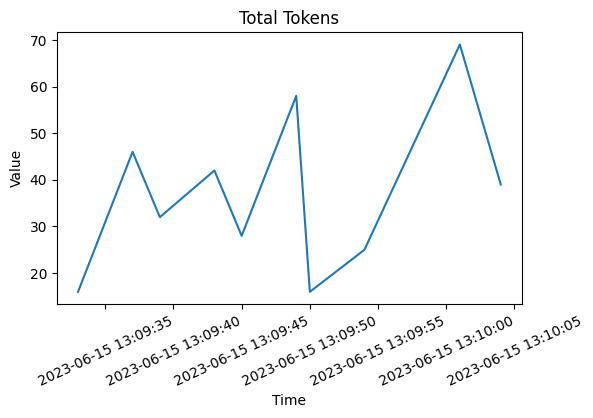

In [5]:
# Helper function to create a graph using matplotlib.
def plot(data, title):
  data = json.loads(data)

  # Extract x and y values from the data
  timestamps = [item["time"] for item in data]
  dates=[dt.datetime.fromtimestamp(ts) for ts in timestamps]
  y = [item["value"] for item in data]

  plt.rcParams['figure.figsize'] = [6, 4]
  plt.subplots_adjust(bottom=0.2)
  plt.xticks(rotation=25 )
  ax=plt.gca()
  xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
  ax.xaxis.set_major_formatter(xfmt)
  
  # Create the plot
  plt.plot(dates, y)

  # Set labels and title
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.title(title)

  plt.show()

response = client.search_ts("__name__", "latency", 0, int(time.time()))
plot(response.text, "Latency")

response = client.search_ts("__name__", "error", 0, int(time.time()))
plot(response.text, "Errors")

response = client.search_ts("__name__", "prompt_tokens", 0, int(time.time()))
plot(response.text, "Prompt Tokens")

response = client.search_ts("__name__", "completion_tokens", 0, int(time.time()))
plot(response.text, "Completion Tokens")

response = client.search_ts("__name__", "total_tokens", 0, int(time.time()))
plot(response.text, "Total Tokens")


## Full text query on prompt or prompt outputs.

In [6]:
# Search for a particular prompt text.
query = "normandy"
response = client.search_log(query, 0, int(time.time()))
print("Results for", query, ":", response.text)

print("===")

query = "king charles III"
response = client.search_log("king charles III", 0, int(time.time()))
print("Results for", query, ":", response.text)


Results for normandy : [{"time":1686814772,"fields":{"prompt":"In what country is Normandy located?"},"text":"In what country is Normandy located?"},{"time":1686814773,"fields":{"prompt_response":"\n\nNormandy is located in France."},"text":"\n\nNormandy is located in France."},{"time":1686814777,"fields":{"prompt_response":"\n\nThe Normans first arrived in Normandy in 911 AD, when the French King Charles the Simple granted them the region in exchange for their help in defending the kingdom against Viking invasions."},"text":"\n\nThe Normans first arrived in Normandy in 911 AD, when the French King Charles the Simple granted them the region in exchange for their help in defending the kingdom against Viking invasions."},{"time":1686814785,"fields":{"prompt":"Who gave their name to Normandy in the 1000's and 1100's"},"text":"Who gave their name to Normandy in the 1000's and 1100's"},{"time":1686814789,"fields":{"prompt_response":"\n\nThe Normans, a people from northern France, gave their

## Step 5: Stop infino server

In [7]:
!docker rm -f infino-example

infino-example
